# **Proyecto de Clasificacion de Razas de Perros**

**Integrantes:**

- Ana B. Gabriel Mercado
- Kevin A. Guzman Marca
- Fernando Tolaba Aguirre
- Adriana A. Montaño Albornoz

In [ ]:
import pandas as pd 
import numpy as np
import tensorflow as tf #Para deep learning (redes neuranales artificiales)
import matplotlib.pyplot as plt
import os 
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator  #Procesar imagenes automaticamente
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image

# Preparacion de Datos

In [2]:
# Ruta de carpetas
base_dir = r'C:\Users\Usuario\OneDrive - UCB\Documentos\UCB\7MO SEMESTRE\INGENIERIA DE DATOS\DOGBREED_CLASIFICATOR\data'   
train_dir = os.path.join(base_dir, 'train')
labels_path = os.path.join(base_dir, 'labels.csv') #Esta carpeta tiene las etiquetas de razas

# archivo labels a dataframe
df = pd.read_csv(labels_path)

# file_path tiene toda la rutita de la imagen
df['file_path'] = df['id'].apply(lambda x: os.path.join(train_dir, x + '.jpg'))

df.head()

,id,breed,file_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,C:\Users\Usuario\OneDrive - UCB\Documentos\UCB...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,C:\Users\Usuario\OneDrive - UCB\Documentos\UCB...
2,001cdf01b096e06d78e9e5112d419397,pekinese,C:\Users\Usuario\OneDrive - UCB\Documentos\UCB...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,C:\Users\Usuario\OneDrive - UCB\Documentos\UCB...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,C:\Users\Usuario\OneDrive - UCB\Documentos\UCB...


In [3]:
# Dividimos 80% entrenamiento y 20% validación, manteniendo proporción de clases
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['breed'], random_state=42)

print("Entrenamiento:", train_df.shape)
print("Validación:", val_df.shape)

Entrenamiento: (8177, 3)
Validación: (2045, 3)


# Preprocesamiento y Aumento de Datos

In [4]:
#Tamaño
img_size = (224, 224)
batch_size = 32

#Generadores train_gen y val_gen que cargan y procesan las imagenes en tiempo real
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)


train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='breed',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='breed',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.


# Construcción y Entrenamiento del Modelo

In [5]:
# Modelo MobileNetV2 preentrenado
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False   # para no entrenar MobileNetV2 de nuevo

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(len(train_gen.class_indices), activation='softmax') #Predice la probabilidad de cada raza
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        15,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,437,432 (9.30 MB)

 Trainable params: 179,448 (700.97 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
#Entrenamos el modelo por 10 epocas usando los datos que preparamos
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.1548 - loss: 3.9634 - val_accuracy: 0.6152 - val_loss: 1.4405
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 204s 798ms/step - accuracy: 0.5034 - loss: 1.8365 - val_accuracy: 0.6812 - val_loss: 1.1186
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 205s 799ms/step - accuracy: 0.5736 - loss: 1.4741 - val_accuracy: 0.6924 - val_loss: 1.0257
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 204s 797ms/step - accuracy: 0.6136 - loss: 1.3248 - val_accuracy: 0.6939 - val_loss: 1.0220
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 201s 786ms/step - accuracy: 0.6255 - loss: 1.2816 - val_accuracy: 0.7032 - val_loss: 0.9919
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 200s 780ms/step - accuracy: 0.6603 - loss: 1.1449 - val_accuracy: 0.7125 - val_loss: 0.9471
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 202s 789ms/step - accuracy: 0.6638 - loss: 1.1090 - val_accuracy: 0.7154 - val_loss: 0.9580
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 200s 781ms/step - accuracy: 0.6858 - lo

La precisión del 71.44% en validación refleja un buen aprendizaje del modelo para diferenciar entre razas de perros. Sin embargo, este valor también sugiere que algunas confusiones persisten, posiblemente por la similitud visual entre ciertas razas o un desbalance en la cantidad de imágenes por clase.

# Ajuste Fino del Modelo

In [7]:
# Descongelamos las últimas 30 capas de MobileNetV2
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Volvemos a compilar con una tasa de aprendizaje más baja para no dañar los pesos preentrenados
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenamiento adicional (fine-tuning)
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5  
)

Epoch 1/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 226s 861ms/step - accuracy: 0.5820 - loss: 1.4781 - val_accuracy: 0.7188 - val_loss: 0.9434
Epoch 2/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.6393 - loss: 1.2559 - val_accuracy: 0.7188 - val_loss: 0.9327
Epoch 3/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 234s 914ms/step - accuracy: 0.6767 - loss: 1.1257 - val_accuracy: 0.7193 - val_loss: 0.9307
Epoch 4/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 226s 883ms/step - accuracy: 0.6785 - loss: 1.0859 - val_accuracy: 0.7242 - val_loss: 0.9154
Epoch 5/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 229s 893ms/step - accuracy: 0.6716 - loss: 1.0706 - val_accuracy: 0.7276 - val_loss: 0.9125


# Evaluación y Visualización

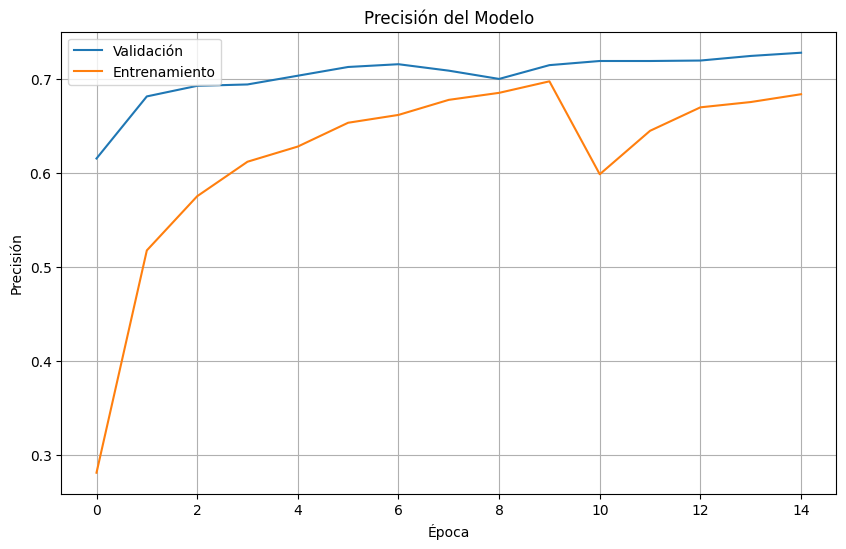

In [8]:
# Gráfica de la precisión
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='Validación')
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'], label='Entrenamiento')
plt.title('Precisión del Modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()

In [9]:
#Medimos rendimiento del modelo sobre val_gen (conjunto de validación)
loss, acc = model.evaluate(val_gen)
print(f"Precisión en validación: {acc*100:.2f}%")

64/64 ━━━━━━━━━━━━━━━━━━━━ 33s 508ms/step - accuracy: 0.7114 - loss: 0.9416
Precisión en validación: 72.76%


La precisión obtenida en el conjunto de validación fue del 73.55%, lo que indica que el modelo es capaz de clasificar correctamente aproximadamente 74 de cada 100 imágenes de razas de perros que no ha visto durante el entrenamiento. Este valor sugiere que el modelo ha aprendido de manera efectiva a reconocer las características distintivas de las diferentes razas, aunque todavía hay margen de mejora, especialmente en aquellas razas que pueden ser visualmente similares entre sí o que están subrepresentadas en los datos. Este nivel de precisión es aceptable considerando la alta cantidad de clases y la variabilidad entre las imágenes.

# Predicción Final/ Resultados

In [10]:
# Traductor inglés -> español con nombres formateados
traductor = {
    "affenpinscher": "Affenpinscher",
    "afghan_hound": "Galgo Afgano",
    "african_hunting_dog": "Perro Salvaje Africano",
    "airedale": "Airedale Terrier",
    "american_staffordshire_terrier": "Staffordshire Terrier Americano",
    "appenzeller": "Appenzeller",
    "australian_terrier": "Terrier Australiano",
    "basenji": "Basenji",
    "basset": "Basset",
    "beagle": "Beagle",
    "bedlington_terrier": "Bedlington Terrier",
    "bernese_mountain_dog": "Boyero De Berna",
    "black-and-tan_coonhound": "Coonhound Negro Y Fuego",
    "blenheim_spaniel": "Spaniel Blenheim",
    "bloodhound": "Sabueso",
    "bluetick": "Bluetick Coonhound",
    "border_collie": "Border Collie",
    "border_terrier": "Border Terrier",
    "borzoi": "Borzoi",
    "boston_bull": "Boston Terrier",
    "bouvier_des_flandres": "Bouvier De Flandes",
    "boxer": "Bóxer",
    "brabancon_griffon": "Grifón De Bruselas",
    "briard": "Briard",
    "brittany_spaniel": "Epagneul Bretón",
    "bull_mastiff": "Bullmastiff",
    "cairn": "Cairn Terrier",
    "cardigan": "Corgi Galés Cardigan",
    "chesapeake_bay_retriever": "Retriever De La Bahía De Chesapeake",
    "chihuahua": "Chihuahua",
    "chow": "Chow Chow",
    "clumber": "Clumber Spaniel",
    "cocker_spaniel": "Cocker Spaniel",
    "collie": "Collie",
    "curly-coated_retriever": "Retriever De Pelo Rizado",
    "dandie_dinmont": "Dandie Dinmont Terrier",
    "dhole": "Cuón",
    "dingo": "Dingo",
    "doberman": "Doberman",
    "english_foxhound": "Foxhound Inglés",
    "english_setter": "Setter Inglés",
    "english_springer": "Springer Spaniel Inglés",
    "entlebucher": "Entlebucher",
    "eskimo_dog": "Perro Esquimal",
    "flat-coated_retriever": "Retriever De Pelo Liso",
    "french_bulldog": "Bulldog Francés",
    "german_shepherd": "Pastor Alemán",
    "german_short-haired_pointer": "Braco Alemán De Pelo Corto",
    "giant_schnauzer": "Schnauzer Gigante",
    "golden_retriever": "Golden Retriever",
    "gordon_setter": "Setter Gordon",
    "great_dane": "Gran Danés",
    "great_pyrenees": "Gran Pirineo",
    "greater_swiss_mountain_dog": "Gran Boyero Suizo",
    "groenendael": "Pastor Belga Groenendael",
    "ibizan_hound": "Podenco Ibicenco",
    "irish_setter": "Setter Irlandés",
    "irish_terrier": "Terrier Irlandés",
    "irish_water_spaniel": "Spaniel De Agua Irlandés",
    "irish_wolfhound": "Lebrel Irlandés",
    "italian_greyhound": "Galgo Italiano",
    "japanese_spaniel": "Spaniel Japonés",
    "keeshond": "Keeshond",
    "kelpie": "Kelpie Australiano",
    "kerry_blue_terrier": "Kerry Blue Terrier",
    "komondor": "Komondor",
    "kuvasz": "Kuvasz",
    "labrador_retriever": "Labrador Retriever",
    "lakeland_terrier": "Lakeland Terrier",
    "leonberg": "Leonberger",
    "lhasa": "Lhasa Apso",
    "malamute": "Alaskan Malamute",
    "malinois": "Pastor Belga Malinois",
    "maltese_dog": "Bichón Maltés",
    "mexican_hairless": "Xoloitzcuintle",
    "miniature_pinscher": "Pinscher Miniatura",
    "miniature_poodle": "Caniche Miniatura",
    "miniature_schnauzer": "Schnauzer Miniatura",
    "newfoundland": "Terranova",
    "norfolk_terrier": "Norfolk Terrier",
    "norwegian_elkhound": "Elkhound Noruego",
    "norwich_terrier": "Norwich Terrier",
    "old_english_sheepdog": "Bobtail",
    "otterhound": "Otterhound",
    "papillon": "Papillon",
    "pekinese": "Pekinés",
    "pembroke": "Corgi Galés Pembroke",
    "pomeranian": "Pomerania",
    "pug": "Pug",
    "redbone": "Redbone Coonhound",
    "rhodesian_ridgeback": "Ridgeback De Rodesia",
    "rottweiler": "Rottweiler",
    "saint_bernard": "San Bernardo",
    "saluki": "Saluki",
    "samoyed": "Samoyedo",
    "schipperke": "Schipperke",
    "scotch_terrier": "Terrier Escocés",
    "scottish_deerhound": "Lebrel Escocés",
    "sealyham_terrier": "Sealyham Terrier",
    "shetland_sheepdog": "Pastor De Shetland",
    "shih-tzu": "Shih Tzu",
    "siberian_husky": "Husky Siberiano",
    "silky_terrier": "Silky Terrier",
    "soft-coated_wheaten_terrier": "Terrier De Trigo De Pelo Suave",
    "staffordshire_bullterrier": "Staffordshire Bull Terrier",
    "standard_poodle": "Caniche Estándar",
    "standard_schnauzer": "Schnauzer Estándar",
    "sussex_spaniel": "Spaniel De Sussex",
    "tibetan_mastiff": "Mastín Tibetano",
    "tibetan_terrier": "Terrier Tibetano",
    "toy_poodle": "Caniche Toy",
    "toy_terrier": "Terrier Toy",
    "vizsla": "Vizsla",
    "walker_hound": "Coonhound De Walker",
    "weimaraner": "Braco De Weimar",
    "welsh_springer_spaniel": "Springer Spaniel Galés",
    "west_highland_white_terrier": "West Highland White Terrier",
    "whippet": "Whippet",
    "wire-haired_fox_terrier": "Fox Terrier De Pelo Duro",
    "yorkshire_terrier": "Yorkshire Terrier"
}


In [11]:
#Cargamos una imagen individual y preprocesamos 

img_path = r'C:\Users\Usuario\OneDrive - UCB\Documentos\UCB\7MO SEMESTRE\INGENIERIA DE DATOS\DOGBREED_CLASIFICATOR\data\test\1a90c33f85f8993f33206816523ad66e.jpg'
img_size = (224, 224)

img = image.load_img(img_path, target_size=img_size) 
img_array = image.img_to_array(img) / 255.0  #Convierte la imagen y divide /255 para normalizar entre 0 y 1
img_array = np.expand_dims(img_array, axis=0) #Solo enviamos una imagen aunque el modelo espere muchas

#Hace prediccion
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions) #la clase con probabilidad mas alta
class_names = list(train_gen.class_indices.keys()) #Obtiene la lista de las razas

predicted_breed_en = class_names[predicted_class]
predicted_breed_es = traductor.get(predicted_breed_en, predicted_breed_en)

print("Predicción:", class_names[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
Predicción: brittany_spaniel


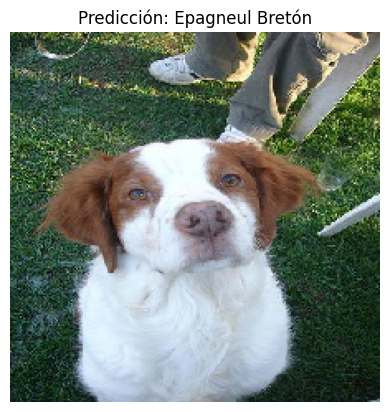

In [12]:
# Imagen con la raza del perro en español como titulo
plt.imshow(img)
plt.title(f"Predicción: {predicted_breed_es}")
plt.axis('off')
plt.show()

In [ ]:
#  GUARDAR EL MODELO ENTRENADO

models_dir = Path("models")
models_path = models_dir / "modelo_entrenado.h5"
model.save(str(models_path))
print(" Modelo guardado como modelo_entrenado.h5")

#  GUARDAR LOS ÍNDICES DE CLASES
import pickle

class_idx_path= models_dir / "class_indices.pkl"
with open(class_idx_path, "wb") as f:
    pickle.dump(train_gen.class_indices, f)

print(f" class_indices guardado en {class_idx_path}")

# Guardamos el diccionario `traductor` como archivo .pkl
trans_path= models_dir / "traducciones.pkl"
with open(trans_path, "wb") as f:
    pickle.dump(traductor, f)

print(f" Diccionario de traducciones guardado en {trans_path}")


NameError: name 'Path' is not defined

El modelo demostró una buena capacidad para distinguir entre múltiples razas de perros, incluso ante desafíos como la variabilidad de iluminación, poses y similitudes entre razas. Logró identificar correctamente razas específicas como el Epagneul Bretón, lo cual evidencia que ha aprendido características visuales relevantes durante el entrenamiento.

Este resultado valida el enfoque utilizado para la preparación de datos y el diseño del modelo, y refuerza su utilidad en escenarios reales de clasificación de imágenes caninas. A futuro, se podría mejorar el rendimiento afinando la arquitectura, incorporando más datos de razas minoritarias o aplicando técnicas de aumento de datos más específicas por clase.